In [1]:
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import tqdm
from tqdm.auto import tqdm;

c:\Tesis\Tesis\Codigo\model_pytorch\venv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Make a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
#GPUS
n_gpus = torch.cuda.device_count()
print(f"Number of gpus: {n_gpus}")

Number of gpus: 1


In [5]:
class ConvBlock (nn.Module):
    def __init__(self,
                in_channels: int,
                out_channels: int,
                 **kwargs): # this means that the key arguments are arbitrary
        super().__init__()

        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                              **kwargs,
                            device=device)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels) # to improve performance
    
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [6]:
class L2NormLayer(nn.Module):
    def __init__(self,dim=1):
        super().__init__()
        self.dim=dim
    
    def forward(self,x):
        return nn.functional.normalize(x,p=2,dim=self.dim)

In [7]:
class InceptionBlock (nn.Module):
        def __init__(self,
                in_channels: int,
                out_1x1: int,

                red_3x3: int,
                out_3x3: int,

                red_5x5: int,
                out_5x5: int,

                out_1x1pool: int,
                
                l2_mode:bool=False):
        
                super().__init__()

                self.branch1 = ConvBlock(in_channels=in_channels,
                                        out_channels=out_1x1,
                                        kernel_size=1)
                
                self.branch2 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_3x3,
                                kernel_size=1),
                        ConvBlock(in_channels=red_3x3,
                                out_channels=out_3x3,
                                kernel_size=3,
                                padding=1) # ojo (btw no ponemos el S bc por defecto es 1)
                )
                
                self.branch3 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_5x5,
                                kernel_size=1),
                        ConvBlock(in_channels=red_5x5,
                                out_channels=out_5x5,
                                kernel_size=5,
                                padding=2) # ojo (btw no ponemos el S bc por defecto es 1)
                )

                if l2_mode:
                        self.branch4=nn.Sequential(
                                L2NormLayer(dim=1),
                                ConvBlock(in_channels=in_channels,
                                out_channels=out_1x1pool,
                                kernel_size=1)
                        )
                else:
                        self.branch4 = nn.Sequential(
                                nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                                ConvBlock(in_channels=in_channels,
                                        out_channels=out_1x1pool,
                                        kernel_size=1)
                        )

        def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
                return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],1)

In [8]:
class InceptionBlock_2(nn.Module):
    def __init__(self, 
                in_channels:int, 
                red_3x3:int,
                out_3x3:int) -> None:
        super().__init__()
        self.branch=nn.Sequential(
            ConvBlock(in_channels=in_channels,
                    out_channels=red_3x3,
                    kernel_size=1),
            ConvBlock(in_channels=red_3x3,
                    out_channels=out_3x3,
                    kernel_size=3)
        )
    def forward(self,x):
        return self.branch(x)

In [9]:
class InceptionBlock_m_3x3 (nn.Module):
        def __init__(self,
                in_channels: int,

                red_3x3: int,
                out_3x3: int,

                red_5x5: int,
                out_5x5: int):
        
                super().__init__()

                self.branch2 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_3x3,
                                kernel_size=1),
                        ConvBlock(in_channels=red_3x3,
                                out_channels=out_3x3,
                                kernel_size=3,
                                padding=1,
                                stride=2) # ojo (btw no ponemos el S bc por defecto es 1)
                )
                
                self.branch3 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_5x5,
                                kernel_size=1),
                        ConvBlock(in_channels=red_5x5,
                                out_channels=out_5x5,
                                kernel_size=5,
                                padding=2,
                                stride=2) # ojo (btw no ponemos el S bc por defecto es 1)
                )

                self.branch4 = nn.Sequential(
                        nn.MaxPool2d(kernel_size=3,stride=2,padding=1), 
                )

        def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
                return torch.cat([self.branch2(x),self.branch3(x),self.branch4(x)],1)

## Structure of the Model

In [10]:
class NN2 (nn.Module):
    def __init__(self,
                in_channels = 3):
        super().__init__()

        self.conv1 = ConvBlock(in_channels=in_channels,
                            out_channels=64,
                            kernel_size=7,
                            stride=2,
                            padding=3)
        
        self.inception2 = InceptionBlock_2(in_channels=64, #la cantidad de canales que entran y salen es la misma. ¿esto es correcto?
                                        red_3x3=64,
                                        out_3x3=192)
    
        self.inception3a = InceptionBlock( in_channels= 192, out_1x1= 64, red_3x3= 96, out_3x3= 128, red_5x5= 16,out_5x5= 32, out_1x1pool= 32)#ok
        self.inception3b = InceptionBlock( in_channels= 256, out_1x1= 64, red_3x3= 96, out_3x3= 128, red_5x5= 32,out_5x5= 64, out_1x1pool= 64,l2_mode=True)
        #modificar desactivando branch 1 y 4
        self.inception3c = InceptionBlock_m_3x3( in_channels= 320, red_3x3= 128, out_3x3= 256, red_5x5= 32,out_5x5= 64)
        
        self.inception4a = InceptionBlock( in_channels= 640, out_1x1= 256, red_3x3= 96, out_3x3= 192, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4b = InceptionBlock( in_channels= 640, out_1x1= 224, red_3x3= 112, out_3x3= 224, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4c = InceptionBlock( in_channels= 640, out_1x1= 192, red_3x3= 128, out_3x3= 256, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4d = InceptionBlock( in_channels= 640, out_1x1= 160, red_3x3= 144, out_3x3= 288, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        #modificar desactivando branch 1 y 4
        self.inception4e = InceptionBlock_m_3x3( in_channels= 640, red_3x3= 160, out_3x3= 256, red_5x5= 64,out_5x5= 128)
        
        self.inception5a = InceptionBlock( in_channels= 1024, out_1x1= 384, red_3x3= 192, out_3x3= 384, red_5x5= 48,out_5x5= 128, out_1x1pool= 128,l2_mode=True)
        self.inception5b = InceptionBlock( in_channels= 1024, out_1x1= 384, red_3x3= 192, out_3x3= 384, red_5x5= 48,out_5x5= 128, out_1x1pool= 128)#ok
        
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1) #por que se aplico un max pool?

        self.avgpool = nn.AvgPool2d(kernel_size=7) # stride? padding?
        
        self.FC = nn.Linear(1024,128)

        self.norm=nn.BatchNorm2d(num_features=64)


    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x=self.norm(x)

        x = self.inception2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.inception3c(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        #print('Despues del inception 5b',x.shape)
        x = self.avgpool(x)
        #print('Despues del avg pool',x.shape)

        x=x.view(x.shape[0],-1)

        x = self.FC(x)
        #print('Despues de fully connected layer',x.shape)
        x = nn.functional.normalize(x,p=2,dim=1)

        return x

In [11]:
torch.manual_seed(42)
model_1 = NN2(in_channels=3).to(device)

In [12]:
#Sample de prueba

sample=torch.randn(size=(1,3,224,224)).to(device)

In [13]:
sample.shape

torch.Size([1, 3, 224, 224])

In [14]:
model_1.eval()
with torch.inference_mode():
    model_1(sample)

## Transform

In [15]:
transform=transforms.Compose([
    transforms.Resize((224,224)),  #Para pasar a 224 x 224 pixels
    transforms.ToTensor()          #Para convertir la imagen a tensor
])

## Path of dataset

In [16]:
import os

print(os.getcwd())

c:\Tesis\Tesis\Codigo\model_pytorch


In [17]:
from pathlib import Path

root_data_path=Path('data')
train_path=root_data_path / 'train'

test_path=root_data_path / 'test'

train_path

WindowsPath('data/train')

In [18]:
img_path_list=list(test_path.glob('*/*.jpg'))

import random
from PIL import Image

random_image_path=random.choice(img_path_list)
img=Image.open(random_image_path)

transform(img).shape

torch.Size([3, 224, 224])

In [19]:
train_data=torchvision.datasets.ImageFolder(train_path,
                                        transform=transform,
                                        target_transform=None)

test_data=torchvision.datasets.ImageFolder(test_path,
                                        transform=transform)

In [20]:
train_data.samples

[('data\\train\\Brayan\\a_rostro_1.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_102.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_109.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_113.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_120.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_124.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_131.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_137.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_145.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_146.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_16.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_163.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_170.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_176.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_183.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_185.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_194.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_200.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_210.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_238.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_239.jpg', 0),
 ('data\\train\\

## Split the data

In [105]:
BATCH_SIZE=32

In [106]:
train_data.class_to_idx

{'Brayan': 0,
 'Carlos_Cruz': 1,
 'Carlos_Pacherres': 2,
 'Cinthia': 3,
 'Eduardo_Crisanto': 4,
 'Elvis': 5,
 'Irene_Alvarado': 6,
 'Pamela': 7,
 'Rodrigo': 8,
 'William': 9,
 'William_Ipanaque': 10}

In [107]:
test_data

Dataset ImageFolder
    Number of datapoints: 1100
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [108]:
train_loader=DataLoader(dataset=train_data,
                        batch_size=BATCH_SIZE,
                        num_workers=2,
                        shuffle=True)

test_loader=DataLoader(dataset=test_data,
                        batch_size=BATCH_SIZE,
                        num_workers=2,
                        shuffle=False)

In [109]:
len(train_loader)

138

In [79]:
image_batch,label_batch=next(iter(train_loader))

In [80]:
len(train_loader)

440

In [81]:
label_batch

tensor([ 0,  2,  7,  6,  9, 10,  2, 10,  3,  7])

In [110]:
optimizer=optim.Adam(params=model_1.parameters(),
                    lr=0.1)
loss_fn=nn.TripletMarginLoss(margin=0.2,p=2)

In [83]:
train_data.class_to_idx

{'Brayan': 0,
 'Carlos_Cruz': 1,
 'Carlos_Pacherres': 2,
 'Cinthia': 3,
 'Eduardo_Crisanto': 4,
 'Elvis': 5,
 'Irene_Alvarado': 6,
 'Pamela': 7,
 'Rodrigo': 8,
 'William': 9,
 'William_Ipanaque': 10}

In [84]:
dict_reference=dict()
for key,value in train_data.class_to_idx.items():
    dict_reference[value]=[]

dict_reference

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}

In [85]:
range(len(dict_reference.keys()))

range(0, 11)

In [86]:
batch_images,batch_labels=next(iter(train_loader))
batch_labels

tensor([ 2,  3,  1,  3,  4, 10,  7,  7,  9,  2])

In [87]:
from copy import deepcopy
import random

In [88]:
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
from pytorch_metric_learning.miners import TripletMarginMiner

distance=CosineSimilarity()
reducer = ThresholdReducer(high=0.3)
embedding_regularizer = LpRegularizer()

In [111]:
loss_func = losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    reducer = ThresholdReducer(high=0.3), 
                                    embedding_regularizer = LpRegularizer())

In [112]:
minig_func=TripletMarginMiner(margin=0.2,distance=distance,type_of_triplets='hard')

In [113]:
def train_step(
        model:torch.nn.Module,
        dataloader:torch.utils.data.dataloader,
        loss_fn:torch.nn.Module,
        optimizer:torch.optim.Optimizer,
        mining_func,
        device):
    
    model.train()

    train_loss,train_acc=0,0

    for batch, (X,y) in enumerate(dataloader):
        #Send data to the target device
        X,y=X.to(device),y.to(device)

        #1. Forward pass
        embeddings=model(X) #Output model logits

        indices_tuple=mining_func(embeddings,y)

        #2. Calculate the loss

        anchors=embeddings[indices_tuple[0]]
        positives=embeddings[indices_tuple[1]]
        negatives=embeddings[indices_tuple[2]]

        loss=loss_fn(anchors,positives,negatives)

        loss=torch.nan_to_num(loss,nan=0.0)

        train_loss+=loss.item()

        #3.Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #Calculate accuracy metric
        # y_pred_class=torch.argmax(torch.softmax(embeddings,dim=1),dim=1)
        # train_acc+= (y_pred_class == y).sum().item() / len(embeddings)

    #Adjust metrics to get average loss and accuracy per batch
    train_loss= train_loss/len(dataloader)
    #train_acc=train_acc / len(dataloader)
    print(train_loss)
    #return train_loss,train_acc
    return train_loss

In [119]:
def test_step(
        model:torch.nn.Module,
        dataloader:torch.utils.data.dataloader,
        loss_fn:torch.nn.Module,
        mining_func,
        device=device):
    
    #Put model in eval mode
    model.eval()

    test_loss,test_acc=0,0

    with torch.inference_mode():
        #Loop through DataLoader batches

        for batch, (X,y) in enumerate(dataloader):
            #Send data to the target device
            X,y=X.to(device),y.to(device)

            #1. Forward pass
            embeddings=model(X)

            indices_tuple=mining_func(embeddings,y)

            anchors=embeddings[indices_tuple[0]]
            positives=embeddings[indices_tuple[1]]
            negatives=embeddings[indices_tuple[2]]

            #2. Calculate the loss
            loss=loss_fn(anchors,positives,negatives)

            loss=torch.nan_to_num(loss,nan=0.0)

            test_loss+=loss.item()

            #3. Calculate the accuracy
            # test_preds_labels=torch.argmax(torch.softmax(embeddings,dim=1),dim=1)
            # test_acc+= (test_preds_labels==y).sum().item() / len(test_preds_labels)

    #Adjust the metrics to get averague loss and accuracy per batch
    test_loss=test_loss / len(dataloader)
    #test_acc=test_acc / len(dataloader)

    #return test_loss,test_acc
    return test_loss

In [120]:
def train_model(model:torch.nn.Module,
        train_dataloader:torch.utils.data.dataloader,
        test_dataloader:torch.utils.data.dataloader,
        optimizer:torch.optim.Optimizer,
        loss_fn:torch.nn.Module,
        minig_func,
        epochs=5,
        device=device):

        #2. Create empty results dictionary
        # results={"train_loss":[],
        #         "train_acc":[],
        #         "test_loss":[],
        #         "test_acc":[]}

        results={"train_loss":[],
                "test_loss":[]}

        #3. Loop through training and testing step for a number of epochs
        for epoch in tqdm(range(epochs)):
                train_loss=train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                mining_func=minig_func,
                                device=device)
                test_loss=test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                mining_func=minig_func,
                                device=device)
        
                #4. Print out what's happening
                #print('Train loss',train_loss)
                #print('Test loss',test_loss)
                print(f"Epoch: {epoch} | Train loss:{train_loss:.4f} | Test loss : {test_loss:.4f}")
                #5. Update results diccionary
                results["train_loss"].append(train_loss)
                results["test_loss"].append(test_loss)

        return results

In [121]:
model_1 = NN2(in_channels=3).to(device)
optimizer=optim.Adam(params=model_1.parameters(),
                    lr=0.1)
loss_fn=nn.TripletMarginLoss(margin=0.2,p=2)

In [130]:
results_model_1=train_model(
    model=model_1,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    minig_func=minig_func,
    epochs=200,
    device=device
)

  0%|          | 0/200 [00:00<?, ?it/s]

0.034830067576705544


  0%|          | 1/200 [00:22<1:14:15, 22.39s/it]

Epoch: 0 | Train loss:0.0348 | Test loss : 0.0000
0.05080522877582605


  1%|          | 2/200 [00:43<1:11:13, 21.58s/it]

Epoch: 1 | Train loss:0.0508 | Test loss : 0.0229
0.07258281198100767


  2%|▏         | 3/200 [01:03<1:09:03, 21.03s/it]

Epoch: 2 | Train loss:0.0726 | Test loss : 0.0115
0.014508834459643433


  2%|▏         | 4/200 [01:24<1:07:40, 20.72s/it]

Epoch: 3 | Train loss:0.0145 | Test loss : 0.0000
0.02175878441852072


  2%|▎         | 5/200 [01:44<1:07:09, 20.66s/it]

Epoch: 4 | Train loss:0.0218 | Test loss : 0.0000
0.004353216916754626


  3%|▎         | 6/200 [02:04<1:06:29, 20.57s/it]

Epoch: 5 | Train loss:0.0044 | Test loss : 0.0057
0.0319455970024717


  4%|▎         | 7/200 [02:25<1:06:00, 20.52s/it]

Epoch: 6 | Train loss:0.0319 | Test loss : 0.0057
0.030484071568302486


  4%|▍         | 8/200 [02:45<1:05:32, 20.48s/it]

Epoch: 7 | Train loss:0.0305 | Test loss : 0.0172
0.020315237775229027


  4%|▍         | 9/200 [03:07<1:06:16, 20.82s/it]

Epoch: 8 | Train loss:0.0203 | Test loss : 0.0000
0.05950021527815556


  5%|▌         | 10/200 [03:27<1:05:42, 20.75s/it]

Epoch: 9 | Train loss:0.0595 | Test loss : 0.0000
0.026118287249751713


  6%|▌         | 11/200 [03:49<1:05:40, 20.85s/it]

Epoch: 10 | Train loss:0.0261 | Test loss : 0.0057
0.02757320067156916


  6%|▌         | 12/200 [04:09<1:04:46, 20.68s/it]

Epoch: 11 | Train loss:0.0276 | Test loss : 0.0057
0.0159577424975409


  6%|▋         | 13/200 [04:30<1:04:51, 20.81s/it]

Epoch: 12 | Train loss:0.0160 | Test loss : 0.0000
0.02030539253483648


  7%|▋         | 14/200 [04:50<1:04:06, 20.68s/it]

Epoch: 13 | Train loss:0.0203 | Test loss : 0.0057
0.014504707053951595


  8%|▊         | 15/200 [05:11<1:03:59, 20.76s/it]

Epoch: 14 | Train loss:0.0145 | Test loss : 0.0057
0.04642543758171192


  8%|▊         | 16/200 [05:32<1:03:21, 20.66s/it]

Epoch: 15 | Train loss:0.0464 | Test loss : 0.0229
0.031915582068588425


  8%|▊         | 17/200 [05:52<1:02:44, 20.57s/it]

Epoch: 16 | Train loss:0.0319 | Test loss : 0.0057
0.02901885431745778


  9%|▉         | 18/200 [06:12<1:02:04, 20.46s/it]

Epoch: 17 | Train loss:0.0290 | Test loss : 0.0000
0.011604594579641369


 10%|▉         | 19/200 [06:33<1:01:40, 20.44s/it]

Epoch: 18 | Train loss:0.0116 | Test loss : 0.0057
0.04352760833242665


 10%|█         | 20/200 [06:53<1:01:12, 20.40s/it]

Epoch: 19 | Train loss:0.0435 | Test loss : 0.0114
0.030471424693646637


 10%|█         | 21/200 [07:13<1:00:51, 20.40s/it]

Epoch: 20 | Train loss:0.0305 | Test loss : 0.0114
0.03916419448627942


 11%|█         | 22/200 [07:34<1:00:26, 20.38s/it]

Epoch: 21 | Train loss:0.0392 | Test loss : 0.0172
0.007248805592889371


 12%|█▏        | 23/200 [07:54<1:00:05, 20.37s/it]

Epoch: 22 | Train loss:0.0072 | Test loss : 0.0000
0.008702618596346481


 12%|█▏        | 24/200 [08:14<59:37, 20.33s/it]  

Epoch: 23 | Train loss:0.0087 | Test loss : 0.0114
0.014508619040682695


 12%|█▎        | 25/200 [08:35<59:36, 20.44s/it]

Epoch: 24 | Train loss:0.0145 | Test loss : 0.0000
0.007250488128351129


 13%|█▎        | 26/200 [08:55<59:07, 20.39s/it]

Epoch: 25 | Train loss:0.0073 | Test loss : 0.0000
0.04061762448670207


 14%|█▎        | 27/200 [09:16<58:54, 20.43s/it]

Epoch: 26 | Train loss:0.0406 | Test loss : 0.0057
0.04641026927941087


 14%|█▍        | 28/200 [09:36<58:24, 20.37s/it]

Epoch: 27 | Train loss:0.0464 | Test loss : 0.0000
0.0159535708202832


 14%|█▍        | 29/200 [09:56<57:59, 20.35s/it]

Epoch: 28 | Train loss:0.0160 | Test loss : 0.0057
0.024654618747856304


 15%|█▌        | 30/200 [10:17<57:45, 20.39s/it]

Epoch: 29 | Train loss:0.0247 | Test loss : 0.0000
0.039170580497686416


 16%|█▌        | 31/200 [10:37<57:36, 20.45s/it]

Epoch: 30 | Train loss:0.0392 | Test loss : 0.0114
0.008702496039694634


 16%|█▌        | 32/200 [10:58<57:41, 20.60s/it]

Epoch: 31 | Train loss:0.0087 | Test loss : 0.0000
0.02030212788478188


 16%|█▋        | 33/200 [11:19<57:13, 20.56s/it]

Epoch: 32 | Train loss:0.0203 | Test loss : 0.0000
0.00869793401680131


 17%|█▋        | 34/200 [11:39<56:33, 20.45s/it]

Epoch: 33 | Train loss:0.0087 | Test loss : 0.0000
0.010150393282157787


 18%|█▊        | 35/200 [12:00<56:19, 20.48s/it]

Epoch: 34 | Train loss:0.0102 | Test loss : 0.0000
0.020311185307260872


 18%|█▊        | 36/200 [12:20<56:04, 20.51s/it]

Epoch: 35 | Train loss:0.0203 | Test loss : 0.0057
0.01015003932558972


 18%|█▊        | 37/200 [12:41<56:05, 20.65s/it]

Epoch: 36 | Train loss:0.0102 | Test loss : 0.0000
0.01884809427935144


 19%|█▉        | 38/200 [13:01<55:25, 20.53s/it]

Epoch: 37 | Train loss:0.0188 | Test loss : 0.0057
0.023199959725573444


 20%|█▉        | 39/200 [13:22<55:14, 20.59s/it]

Epoch: 38 | Train loss:0.0232 | Test loss : 0.0057
0.02900381785803947


 20%|██        | 40/200 [13:42<54:41, 20.51s/it]

Epoch: 39 | Train loss:0.0290 | Test loss : 0.0057
0.04061077988666037


 20%|██        | 41/200 [14:03<54:14, 20.47s/it]

Epoch: 40 | Train loss:0.0406 | Test loss : 0.0229
0.043510954449142235


 21%|██        | 42/200 [14:23<53:50, 20.45s/it]

Epoch: 41 | Train loss:0.0435 | Test loss : 0.0114
0.02030222970938337


 22%|██▏       | 43/200 [14:43<53:23, 20.40s/it]

Epoch: 42 | Train loss:0.0203 | Test loss : 0.0000
0.0


 22%|██▏       | 44/200 [15:04<53:01, 20.39s/it]

Epoch: 43 | Train loss:0.0000 | Test loss : 0.0000
0.0


 22%|██▎       | 45/200 [15:24<52:36, 20.37s/it]

Epoch: 44 | Train loss:0.0000 | Test loss : 0.0000
0.007249025762944982


 23%|██▎       | 46/200 [15:45<52:51, 20.59s/it]

Epoch: 45 | Train loss:0.0072 | Test loss : 0.0114
0.037700800900010094


 24%|██▎       | 47/200 [16:05<52:15, 20.49s/it]

Epoch: 46 | Train loss:0.0377 | Test loss : 0.0057
0.06090821260991304


 24%|██▍       | 48/200 [16:26<51:48, 20.45s/it]

Epoch: 47 | Train loss:0.0609 | Test loss : 0.0172
0.04060858077761056


 24%|██▍       | 49/200 [16:46<51:32, 20.48s/it]

Epoch: 48 | Train loss:0.0406 | Test loss : 0.0172
0.029007263049699257


 25%|██▌       | 50/200 [17:07<51:00, 20.40s/it]

Epoch: 49 | Train loss:0.0290 | Test loss : 0.0000
0.005798700171104376


 26%|██▌       | 51/200 [17:27<50:32, 20.35s/it]

Epoch: 50 | Train loss:0.0058 | Test loss : 0.0000
0.001449361875437308


 26%|██▌       | 52/200 [17:47<50:08, 20.33s/it]

Epoch: 51 | Train loss:0.0014 | Test loss : 0.0000
0.0014497555684352267


 26%|██▋       | 53/200 [18:08<50:03, 20.43s/it]

Epoch: 52 | Train loss:0.0014 | Test loss : 0.0000
0.011596325730931932


 27%|██▋       | 54/200 [18:28<49:53, 20.50s/it]

Epoch: 53 | Train loss:0.0116 | Test loss : 0.0057
0.010148084142069885


 28%|██▊       | 55/200 [18:49<49:34, 20.52s/it]

Epoch: 54 | Train loss:0.0101 | Test loss : 0.0057
0.023199133898900902


 28%|██▊       | 56/200 [19:09<49:10, 20.49s/it]

Epoch: 55 | Train loss:0.0232 | Test loss : 0.0000
0.03335154510062674


 28%|██▊       | 57/200 [19:30<48:50, 20.49s/it]

Epoch: 56 | Train loss:0.0334 | Test loss : 0.0000
0.028992519322512806


 29%|██▉       | 58/200 [19:50<48:26, 20.47s/it]

Epoch: 57 | Train loss:0.0290 | Test loss : 0.0000
0.010145028216251429


 30%|██▉       | 59/200 [20:11<48:06, 20.47s/it]

Epoch: 58 | Train loss:0.0101 | Test loss : 0.0057
0.03624612114567687


 30%|███       | 60/200 [20:31<47:52, 20.52s/it]

Epoch: 59 | Train loss:0.0362 | Test loss : 0.0057
0.030451491151167


 30%|███       | 61/200 [20:52<47:39, 20.57s/it]

Epoch: 60 | Train loss:0.0305 | Test loss : 0.0229
0.015947537145752838


 31%|███       | 62/200 [21:13<47:14, 20.54s/it]

Epoch: 61 | Train loss:0.0159 | Test loss : 0.0000
0.0057989036043485


 32%|███▏      | 63/200 [21:33<47:00, 20.58s/it]

Epoch: 62 | Train loss:0.0058 | Test loss : 0.0000
0.02898754989323409


 32%|███▏      | 64/200 [21:54<46:41, 20.60s/it]

Epoch: 63 | Train loss:0.0290 | Test loss : 0.0286
0.04204931077749833


 32%|███▎      | 65/200 [22:14<46:19, 20.59s/it]

Epoch: 64 | Train loss:0.0420 | Test loss : 0.0057
0.024646387907905853


 33%|███▎      | 66/200 [22:35<45:53, 20.55s/it]

Epoch: 65 | Train loss:0.0246 | Test loss : 0.0057
0.013046480067398237


 34%|███▎      | 67/200 [22:55<45:28, 20.52s/it]

Epoch: 66 | Train loss:0.0130 | Test loss : 0.0057
0.002899523014607637


 34%|███▍      | 68/200 [23:16<45:01, 20.46s/it]

Epoch: 67 | Train loss:0.0029 | Test loss : 0.0000
0.011598896073258442


 34%|███▍      | 69/200 [23:36<44:40, 20.46s/it]

Epoch: 68 | Train loss:0.0116 | Test loss : 0.0000
0.007252902656361676


 35%|███▌      | 70/200 [23:57<44:29, 20.53s/it]

Epoch: 69 | Train loss:0.0073 | Test loss : 0.0057
0.0


 36%|███▌      | 71/200 [24:17<44:10, 20.55s/it]

Epoch: 70 | Train loss:0.0000 | Test loss : 0.0057
0.011600097452384838


 36%|███▌      | 72/200 [24:38<43:44, 20.50s/it]

Epoch: 71 | Train loss:0.0116 | Test loss : 0.0171
0.018845928643924603


 36%|███▋      | 73/200 [24:59<43:34, 20.59s/it]

Epoch: 72 | Train loss:0.0188 | Test loss : 0.0114
0.04494732369979223


 37%|███▋      | 74/200 [25:19<43:05, 20.52s/it]

Epoch: 73 | Train loss:0.0449 | Test loss : 0.0229
0.023191453106161476


 38%|███▊      | 75/200 [25:39<42:41, 20.49s/it]

Epoch: 74 | Train loss:0.0232 | Test loss : 0.0000
0.007249185140582098


 38%|███▊      | 76/200 [25:59<42:00, 20.33s/it]

Epoch: 75 | Train loss:0.0072 | Test loss : 0.0057
0.0028991910858430724


 38%|███▊      | 77/200 [43:34<11:18:02, 330.76s/it]

Epoch: 76 | Train loss:0.0029 | Test loss : 0.0000
0.01304695690455644


 39%|███▉      | 78/200 [43:56<8:03:40, 237.88s/it] 

Epoch: 77 | Train loss:0.0130 | Test loss : 0.0000
0.013046851732592651


 40%|███▉      | 79/200 [44:16<5:48:21, 172.74s/it]

Epoch: 78 | Train loss:0.0130 | Test loss : 0.0000
0.0159501972189848


 40%|████      | 80/200 [44:37<4:13:59, 126.99s/it]

Epoch: 79 | Train loss:0.0160 | Test loss : 0.0000
0.014497348471828129


 40%|████      | 81/200 [44:57<3:08:30, 95.05s/it] 

Epoch: 80 | Train loss:0.0145 | Test loss : 0.0172
0.011599485317002172


 41%|████      | 82/200 [45:17<2:22:49, 72.62s/it]

Epoch: 81 | Train loss:0.0116 | Test loss : 0.0057
0.02609925727913345


 42%|████▏     | 83/200 [45:38<1:50:58, 56.91s/it]

Epoch: 82 | Train loss:0.0261 | Test loss : 0.0000
0.024649854155554287


 42%|████▏     | 84/200 [45:58<1:28:52, 45.97s/it]

Epoch: 83 | Train loss:0.0246 | Test loss : 0.0057
0.010150708474110866


 42%|████▎     | 85/200 [46:18<1:13:21, 38.28s/it]

Epoch: 84 | Train loss:0.0102 | Test loss : 0.0000
0.004350021049596261


 43%|████▎     | 86/200 [46:39<1:02:31, 32.90s/it]

Epoch: 85 | Train loss:0.0044 | Test loss : 0.0000
0.004350251909615337


 44%|████▎     | 87/200 [47:00<55:05, 29.25s/it]  

Epoch: 86 | Train loss:0.0044 | Test loss : 0.0000
0.0014494101422420447


 44%|████▍     | 88/200 [47:20<49:42, 26.63s/it]

Epoch: 87 | Train loss:0.0014 | Test loss : 0.0000
0.0


 44%|████▍     | 89/200 [47:40<45:45, 24.73s/it]

Epoch: 88 | Train loss:0.0000 | Test loss : 0.0000
0.004348010472629381


 45%|████▌     | 90/200 [48:01<43:06, 23.51s/it]

Epoch: 89 | Train loss:0.0043 | Test loss : 0.0286
0.020296820479890575


 46%|████▌     | 91/200 [48:22<41:25, 22.80s/it]

Epoch: 90 | Train loss:0.0203 | Test loss : 0.0000
0.0028989477002102394


 46%|████▌     | 92/200 [48:43<39:49, 22.12s/it]

Epoch: 91 | Train loss:0.0029 | Test loss : 0.0172
0.020303508401780888


 46%|████▋     | 93/200 [49:04<38:54, 21.82s/it]

Epoch: 92 | Train loss:0.0203 | Test loss : 0.0114
0.008695410321588102


 47%|████▋     | 94/200 [49:24<37:50, 21.42s/it]

Epoch: 93 | Train loss:0.0087 | Test loss : 0.0000
0.0028993166659189305


 48%|████▊     | 95/200 [49:45<36:58, 21.12s/it]

Epoch: 94 | Train loss:0.0029 | Test loss : 0.0000
0.013048305675603342


 48%|████▊     | 96/200 [50:05<36:24, 21.01s/it]

Epoch: 95 | Train loss:0.0130 | Test loss : 0.0057
0.007249028462430705


 48%|████▊     | 97/200 [50:26<35:56, 20.93s/it]

Epoch: 96 | Train loss:0.0072 | Test loss : 0.0000
0.002898665873900704


 49%|████▉     | 98/200 [50:47<35:26, 20.85s/it]

Epoch: 97 | Train loss:0.0029 | Test loss : 0.0000
0.004348064894261567


 50%|████▉     | 99/200 [51:07<34:53, 20.72s/it]

Epoch: 98 | Train loss:0.0043 | Test loss : 0.0057
0.0014495862566906474


 50%|█████     | 100/200 [51:28<34:29, 20.69s/it]

Epoch: 99 | Train loss:0.0014 | Test loss : 0.0000
0.005797794547633848


 50%|█████     | 101/200 [51:49<34:16, 20.77s/it]

Epoch: 100 | Train loss:0.0058 | Test loss : 0.0000
0.021756475710350533


 51%|█████     | 102/200 [52:10<34:08, 20.90s/it]

Epoch: 101 | Train loss:0.0218 | Test loss : 0.0000
0.0232101243691168


 52%|█████▏    | 103/200 [52:31<33:34, 20.77s/it]

Epoch: 102 | Train loss:0.0232 | Test loss : 0.0057
0.014496317376261171


 52%|█████▏    | 104/200 [52:51<33:00, 20.63s/it]

Epoch: 103 | Train loss:0.0145 | Test loss : 0.0000
0.004346169207407081


 52%|█████▎    | 105/200 [53:11<32:28, 20.51s/it]

Epoch: 104 | Train loss:0.0043 | Test loss : 0.0000
0.0


 53%|█████▎    | 106/200 [53:31<32:02, 20.45s/it]

Epoch: 105 | Train loss:0.0000 | Test loss : 0.0000
0.0014481908385304437


 54%|█████▎    | 107/200 [53:52<31:36, 20.39s/it]

Epoch: 106 | Train loss:0.0014 | Test loss : 0.0057
0.008700031841146772


 54%|█████▍    | 108/200 [54:12<31:20, 20.44s/it]

Epoch: 107 | Train loss:0.0087 | Test loss : 0.0057
0.002899502066598422


 55%|█████▍    | 109/200 [54:32<30:53, 20.37s/it]

Epoch: 108 | Train loss:0.0029 | Test loss : 0.0057
0.01304600873719091


 55%|█████▌    | 110/200 [54:53<30:31, 20.35s/it]

Epoch: 109 | Train loss:0.0130 | Test loss : 0.0000
0.0028982098767722864


 56%|█████▌    | 111/200 [55:13<30:05, 20.29s/it]

Epoch: 110 | Train loss:0.0029 | Test loss : 0.0000
0.002898762731448464


 56%|█████▌    | 112/200 [55:33<29:44, 20.28s/it]

Epoch: 111 | Train loss:0.0029 | Test loss : 0.0000
0.0014480412870213606


 56%|█████▋    | 113/200 [55:53<29:21, 20.25s/it]

Epoch: 112 | Train loss:0.0014 | Test loss : 0.0000
0.010144929415073948


 57%|█████▋    | 114/200 [56:14<29:06, 20.31s/it]

Epoch: 113 | Train loss:0.0101 | Test loss : 0.0057
0.03190193843582402


 57%|█████▊    | 115/200 [56:34<28:44, 20.29s/it]

Epoch: 114 | Train loss:0.0319 | Test loss : 0.0114
0.01594729246436686


 58%|█████▊    | 116/200 [56:55<28:46, 20.55s/it]

Epoch: 115 | Train loss:0.0159 | Test loss : 0.0000
0.008699440545793892


 58%|█████▊    | 117/200 [57:16<28:27, 20.58s/it]

Epoch: 116 | Train loss:0.0087 | Test loss : 0.0057
0.004349174274914507


 59%|█████▉    | 118/200 [57:36<28:03, 20.53s/it]

Epoch: 117 | Train loss:0.0043 | Test loss : 0.0000
0.00725090698055599


 60%|█████▉    | 119/200 [57:57<27:38, 20.48s/it]

Epoch: 118 | Train loss:0.0073 | Test loss : 0.0057
0.001449736564055733


 60%|██████    | 120/200 [58:17<27:15, 20.45s/it]

Epoch: 119 | Train loss:0.0014 | Test loss : 0.0057
0.004349963820498922


 60%|██████    | 121/200 [58:37<26:48, 20.36s/it]

Epoch: 120 | Train loss:0.0043 | Test loss : 0.0000
0.0


 61%|██████    | 122/200 [58:57<26:25, 20.32s/it]

Epoch: 121 | Train loss:0.0000 | Test loss : 0.0000
0.0


 62%|██████▏   | 123/200 [59:18<26:10, 20.39s/it]

Epoch: 122 | Train loss:0.0000 | Test loss : 0.0000
0.001450228518333988


 62%|██████▏   | 124/200 [59:38<25:50, 20.40s/it]

Epoch: 123 | Train loss:0.0015 | Test loss : 0.0000
0.002901023388772771


 62%|██████▎   | 125/200 [59:59<25:28, 20.38s/it]

Epoch: 124 | Train loss:0.0029 | Test loss : 0.0000
0.002901275628718777


 63%|██████▎   | 126/200 [1:00:19<25:09, 20.40s/it]

Epoch: 125 | Train loss:0.0029 | Test loss : 0.0000
0.0


 64%|██████▎   | 127/200 [1:00:39<24:48, 20.39s/it]

Epoch: 126 | Train loss:0.0000 | Test loss : 0.0000
0.0


 64%|██████▍   | 128/200 [1:01:00<24:33, 20.47s/it]

Epoch: 127 | Train loss:0.0000 | Test loss : 0.0000
0.0


 64%|██████▍   | 129/200 [1:01:20<24:06, 20.38s/it]

Epoch: 128 | Train loss:0.0000 | Test loss : 0.0000
0.0


 65%|██████▌   | 130/200 [1:01:41<23:44, 20.35s/it]

Epoch: 129 | Train loss:0.0000 | Test loss : 0.0000
0.0


 66%|██████▌   | 131/200 [1:02:01<23:20, 20.30s/it]

Epoch: 130 | Train loss:0.0000 | Test loss : 0.0000
0.0


 66%|██████▌   | 132/200 [1:02:21<22:58, 20.27s/it]

Epoch: 131 | Train loss:0.0000 | Test loss : 0.0000
0.0


 66%|██████▋   | 133/200 [1:02:41<22:40, 20.31s/it]

Epoch: 132 | Train loss:0.0000 | Test loss : 0.0000
0.0


 67%|██████▋   | 134/200 [1:03:02<22:20, 20.31s/it]

Epoch: 133 | Train loss:0.0000 | Test loss : 0.0000
0.0


 68%|██████▊   | 135/200 [1:03:22<21:57, 20.27s/it]

Epoch: 134 | Train loss:0.0000 | Test loss : 0.0000
0.0


 68%|██████▊   | 136/200 [1:03:42<21:37, 20.27s/it]

Epoch: 135 | Train loss:0.0000 | Test loss : 0.0000
0.0


 68%|██████▊   | 137/200 [1:04:02<21:14, 20.24s/it]

Epoch: 136 | Train loss:0.0000 | Test loss : 0.0000
0.0


 69%|██████▉   | 138/200 [1:04:23<20:56, 20.27s/it]

Epoch: 137 | Train loss:0.0000 | Test loss : 0.0000
0.0


 70%|██████▉   | 139/200 [1:04:43<20:35, 20.25s/it]

Epoch: 138 | Train loss:0.0000 | Test loss : 0.0000
0.0


 70%|███████   | 140/200 [1:05:03<20:13, 20.23s/it]

Epoch: 139 | Train loss:0.0000 | Test loss : 0.0000
0.0


 70%|███████   | 141/200 [1:05:23<19:53, 20.23s/it]

Epoch: 140 | Train loss:0.0000 | Test loss : 0.0000
0.0


 71%|███████   | 142/200 [1:05:44<19:34, 20.25s/it]

Epoch: 141 | Train loss:0.0000 | Test loss : 0.0000
0.0


 72%|███████▏  | 143/200 [1:06:04<19:12, 20.21s/it]

Epoch: 142 | Train loss:0.0000 | Test loss : 0.0000
0.0


 72%|███████▏  | 144/200 [1:06:24<18:50, 20.19s/it]

Epoch: 143 | Train loss:0.0000 | Test loss : 0.0000
0.0


 72%|███████▎  | 145/200 [1:06:44<18:32, 20.22s/it]

Epoch: 144 | Train loss:0.0000 | Test loss : 0.0000
0.0


 73%|███████▎  | 146/200 [1:07:04<18:11, 20.21s/it]

Epoch: 145 | Train loss:0.0000 | Test loss : 0.0000
0.0


 74%|███████▎  | 147/200 [1:07:25<17:53, 20.25s/it]

Epoch: 146 | Train loss:0.0000 | Test loss : 0.0000
0.0


 74%|███████▍  | 148/200 [1:07:45<17:31, 20.22s/it]

Epoch: 147 | Train loss:0.0000 | Test loss : 0.0000
0.0


 74%|███████▍  | 149/200 [1:08:05<17:09, 20.18s/it]

Epoch: 148 | Train loss:0.0000 | Test loss : 0.0000
0.0


 75%|███████▌  | 150/200 [1:08:25<16:49, 20.19s/it]

Epoch: 149 | Train loss:0.0000 | Test loss : 0.0000
0.0


 76%|███████▌  | 151/200 [1:08:45<16:30, 20.22s/it]

Epoch: 150 | Train loss:0.0000 | Test loss : 0.0000
0.0


 76%|███████▌  | 152/200 [1:09:06<16:12, 20.26s/it]

Epoch: 151 | Train loss:0.0000 | Test loss : 0.0000
0.0


 76%|███████▋  | 153/200 [1:09:26<15:54, 20.31s/it]

Epoch: 152 | Train loss:0.0000 | Test loss : 0.0000
0.05367191157479217


 77%|███████▋  | 154/200 [1:09:46<15:33, 20.28s/it]

Epoch: 153 | Train loss:0.0537 | Test loss : 0.0515
0.11015784006187881


 78%|███████▊  | 155/200 [1:10:07<15:16, 20.36s/it]

Epoch: 154 | Train loss:0.1102 | Test loss : 0.0114
0.02609237121499103


 78%|███████▊  | 156/200 [1:10:27<14:56, 20.36s/it]

Epoch: 155 | Train loss:0.0261 | Test loss : 0.0057
0.011593733360801918


 78%|███████▊  | 157/200 [1:10:48<14:34, 20.34s/it]

Epoch: 156 | Train loss:0.0116 | Test loss : 0.0000
0.008698284841965939


 79%|███████▉  | 158/200 [1:11:08<14:12, 20.30s/it]

Epoch: 157 | Train loss:0.0087 | Test loss : 0.0000
0.001448174209698387


 80%|███████▉  | 159/200 [1:11:28<13:51, 20.28s/it]

Epoch: 158 | Train loss:0.0014 | Test loss : 0.0000
0.0014486669198326442


 80%|████████  | 160/200 [1:11:48<13:29, 20.23s/it]

Epoch: 159 | Train loss:0.0014 | Test loss : 0.0057
0.0014487412096797557


 80%|████████  | 161/200 [1:12:08<13:07, 20.19s/it]

Epoch: 160 | Train loss:0.0014 | Test loss : 0.0000
0.0014491275600765061


 81%|████████  | 162/200 [1:12:28<12:47, 20.19s/it]

Epoch: 161 | Train loss:0.0014 | Test loss : 0.0000
0.005796935787235481


 82%|████████▏ | 163/200 [1:12:49<12:30, 20.27s/it]

Epoch: 162 | Train loss:0.0058 | Test loss : 0.0000
0.02319604169199432


 82%|████████▏ | 164/200 [1:13:09<12:10, 20.30s/it]

Epoch: 163 | Train loss:0.0232 | Test loss : 0.0000
0.011599046488602957


 82%|████████▎ | 165/200 [1:13:30<11:50, 20.29s/it]

Epoch: 164 | Train loss:0.0116 | Test loss : 0.0000
0.005794733006885086


 83%|████████▎ | 166/200 [1:13:50<11:29, 20.27s/it]

Epoch: 165 | Train loss:0.0058 | Test loss : 0.0000
0.0028990057931430097


 84%|████████▎ | 167/200 [1:14:10<11:08, 20.27s/it]

Epoch: 166 | Train loss:0.0029 | Test loss : 0.0000
0.0


 84%|████████▍ | 168/200 [1:14:30<10:48, 20.27s/it]

Epoch: 167 | Train loss:0.0000 | Test loss : 0.0000
0.0


 84%|████████▍ | 169/200 [1:14:51<10:29, 20.29s/it]

Epoch: 168 | Train loss:0.0000 | Test loss : 0.0000
0.0014494100342626157


 85%|████████▌ | 170/200 [1:15:11<10:06, 20.22s/it]

Epoch: 169 | Train loss:0.0014 | Test loss : 0.0000
0.0028995933092158775


 86%|████████▌ | 171/200 [1:15:31<09:46, 20.23s/it]

Epoch: 170 | Train loss:0.0029 | Test loss : 0.0000
0.020297214172888493


 86%|████████▌ | 172/200 [1:15:51<09:25, 20.21s/it]

Epoch: 171 | Train loss:0.0203 | Test loss : 0.0057
0.015947163968846417


 86%|████████▋ | 173/200 [1:16:11<09:05, 20.19s/it]

Epoch: 172 | Train loss:0.0159 | Test loss : 0.0114
0.0072477326013039856


 87%|████████▋ | 174/200 [1:16:32<08:45, 20.22s/it]

Epoch: 173 | Train loss:0.0072 | Test loss : 0.0057
0.004349953238514887


 88%|████████▊ | 175/200 [1:16:52<08:26, 20.24s/it]

Epoch: 174 | Train loss:0.0043 | Test loss : 0.0000
0.0014490720586500306


 88%|████████▊ | 176/200 [1:17:12<08:05, 20.23s/it]

Epoch: 175 | Train loss:0.0014 | Test loss : 0.0000
0.0


 88%|████████▊ | 177/200 [1:17:33<07:49, 20.41s/it]

Epoch: 176 | Train loss:0.0000 | Test loss : 0.0000
0.0


 89%|████████▉ | 178/200 [1:17:54<07:31, 20.51s/it]

Epoch: 177 | Train loss:0.0000 | Test loss : 0.0000
0.0


 90%|████████▉ | 179/200 [1:18:14<07:09, 20.46s/it]

Epoch: 178 | Train loss:0.0000 | Test loss : 0.0000
0.0


 90%|█████████ | 180/200 [1:18:34<06:49, 20.45s/it]

Epoch: 179 | Train loss:0.0000 | Test loss : 0.0000
0.0


 90%|█████████ | 181/200 [1:18:55<06:28, 20.47s/it]

Epoch: 180 | Train loss:0.0000 | Test loss : 0.0000
0.0


 91%|█████████ | 182/200 [1:19:17<06:17, 20.99s/it]

Epoch: 181 | Train loss:0.0000 | Test loss : 0.0000
0.0


 92%|█████████▏| 183/200 [1:19:39<05:59, 21.13s/it]

Epoch: 182 | Train loss:0.0000 | Test loss : 0.0000
0.0


 92%|█████████▏| 184/200 [1:19:59<05:35, 20.97s/it]

Epoch: 183 | Train loss:0.0000 | Test loss : 0.0000
0.0


 92%|█████████▎| 185/200 [1:20:20<05:12, 20.80s/it]

Epoch: 184 | Train loss:0.0000 | Test loss : 0.0000
0.0


 93%|█████████▎| 186/200 [1:20:40<04:48, 20.62s/it]

Epoch: 185 | Train loss:0.0000 | Test loss : 0.0000
0.0


 94%|█████████▎| 187/200 [1:21:00<04:26, 20.50s/it]

Epoch: 186 | Train loss:0.0000 | Test loss : 0.0000
0.0


 94%|█████████▍| 188/200 [1:21:21<04:06, 20.51s/it]

Epoch: 187 | Train loss:0.0000 | Test loss : 0.0000
0.0


 94%|█████████▍| 189/200 [1:21:41<03:44, 20.44s/it]

Epoch: 188 | Train loss:0.0000 | Test loss : 0.0000
0.0


 95%|█████████▌| 190/200 [1:22:01<03:24, 20.45s/it]

Epoch: 189 | Train loss:0.0000 | Test loss : 0.0000
0.0


 96%|█████████▌| 191/200 [1:22:22<03:05, 20.56s/it]

Epoch: 190 | Train loss:0.0000 | Test loss : 0.0000
0.0


 96%|█████████▌| 192/200 [1:22:43<02:44, 20.53s/it]

Epoch: 191 | Train loss:0.0000 | Test loss : 0.0000
0.0


 96%|█████████▋| 193/200 [1:23:03<02:24, 20.58s/it]

Epoch: 192 | Train loss:0.0000 | Test loss : 0.0000
0.0


 97%|█████████▋| 194/200 [1:23:24<02:03, 20.53s/it]

Epoch: 193 | Train loss:0.0000 | Test loss : 0.0000
0.0


 98%|█████████▊| 195/200 [1:23:44<01:42, 20.48s/it]

Epoch: 194 | Train loss:0.0000 | Test loss : 0.0000
0.0


 98%|█████████▊| 196/200 [1:24:04<01:21, 20.44s/it]

Epoch: 195 | Train loss:0.0000 | Test loss : 0.0000
0.0


 98%|█████████▊| 197/200 [1:24:25<01:01, 20.41s/it]

Epoch: 196 | Train loss:0.0000 | Test loss : 0.0000
0.0


 99%|█████████▉| 198/200 [1:24:45<00:40, 20.37s/it]

Epoch: 197 | Train loss:0.0000 | Test loss : 0.0000
0.0


100%|█████████▉| 199/200 [1:25:05<00:20, 20.40s/it]

Epoch: 198 | Train loss:0.0000 | Test loss : 0.0000
0.0


100%|██████████| 200/200 [1:25:26<00:00, 25.63s/it]

Epoch: 199 | Train loss:0.0000 | Test loss : 0.0000


In [125]:
from typing import Dict,List

In [128]:
def plot_loss_curves(results:Dict[str,List[float]]):
    """
    Plots training curves of a results dictionary.
    """
    #Get the loss values of the results dictionary (training and test)
    loss=results["train_loss"]
    test_loss=results["test_loss"]

    #Get the accuracy values of the results dictionary (training and test)
    #acc=results["train_acc"]
    #test_acc=results["test_acc"]

    #Figure out how many epochs there where
    epochs=range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    #Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label='train_loss')
    plt.plot(epochs,test_loss,label='test_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot the accuracy
    #plt.subplot(1,2,2)
    #plt.plot(epochs,acc,label='train_acc')
    #plt.plot(epochs,test_acc,label='test_acc')
    #plt.title("Accuracy")
    #plt.xlabel("Epochs")
    #plt.legend()

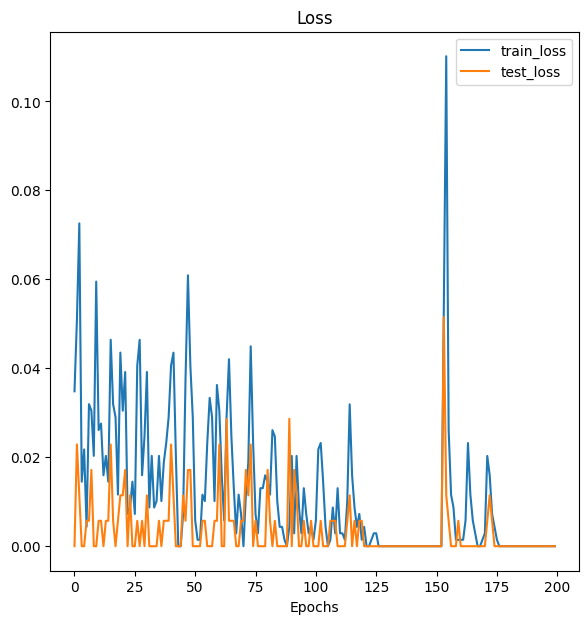

In [131]:
plot_loss_curves(results_model_1)